In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle

In [2]:
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [46]:
!gsutil ls gs://tibot-ml-labeling/datasets/**

gs://tibot-ml-labeling/datasets/Humanbody/Diganto/dataset.zip
gs://tibot-ml-labeling/datasets/Humanbody/gaju/HbodyDataset.zip
gs://tibot-ml-labeling/datasets/Humanbody/rifat/human_dataset.zip
gs://tibot-ml-labeling/datasets/cats_vs_dogs_dataset.zip
gs://tibot-ml-labeling/datasets/kvasir/diganto_efficientvit_m3_2600.pkl
gs://tibot-ml-labeling/datasets/kvasir/diganto_efficientvit_m3_320.pkl
gs://tibot-ml-labeling/datasets/kvasir/fastVit_T8_features.pkl
gs://tibot-ml-labeling/datasets/kvasir/rifat_mobileOne_s4_2048.pkl


In [47]:
!gsutil -mq cp gs://tibot-ml-labeling/datasets/kvasir/fastVit_T8_features.pkl ./

In [48]:
!gsutil -mq cp gs://tibot-ml-labeling/datasets/kvasir/rifat_mobileOne_s4_2048.pkl ./

# Load Pickle

In [4]:
import pickle

filepath = 'drive/MyDrive/feature/diganto_efficientvit_m3_320.pkl'

# Save the dictionary into a pickle file
with open(filepath, 'rb') as f:
    feature_dict = pickle.load(f)

In [49]:
filepath = '/content/rifat_mobileOne_s4_2048.pkl'

# Save the dictionary into a pickle file
with open(filepath, 'rb') as f:
    feature_dict_rifat = pickle.load(f)

In [51]:
filepath = '/content/fastVit_T8_features.pkl'

# Save the dictionary into a pickle file
with open(filepath, 'rb') as f:
    feature_dict_gaju = pickle.load(f)

# EfficientVitM3 features

## EDA

In [84]:
X = feature_dict['features']
Y = feature_dict['label']

In [85]:
# Convert the list of feature arrays to a DataFrame
df = pd.DataFrame(X)
df['class'] = Y

In [34]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,class
0,-2.528192,-6.607552,-9.971182,-2.110953,26.845852,-12.796398,1.073490,2.507070,4.491453,1.222635,...,-1.181589,-3.512823,0.263605,-0.434646,0.936138,-3.336556,6.705895,3.875189,-2.464638,dyed-lifted-polyps
1,-5.080381,-2.686096,-10.542160,-0.750151,27.379881,-12.802082,1.333564,-0.326514,-0.125084,0.766131,...,2.545212,-5.507615,0.200104,-0.619598,0.676777,-3.322640,6.763563,3.956251,-2.542947,dyed-lifted-polyps
2,-1.895429,-6.398154,-9.378530,-0.509677,28.583794,-11.966479,-4.498934,0.301890,-0.601332,0.221790,...,1.246223,-4.926346,0.732132,0.108200,0.511949,-7.704895,5.995973,3.708626,-2.870436,dyed-lifted-polyps
3,-3.844713,-5.426737,-8.597269,-2.620388,27.641174,-13.773445,-4.418326,0.038130,-1.376938,1.037800,...,1.798866,-5.932832,0.819516,-0.381854,0.596074,-3.814690,6.502958,4.142476,-5.241688,dyed-lifted-polyps
4,-3.257241,-3.893371,-8.911982,-0.457302,26.229643,-13.227119,1.146942,-0.027350,-0.941652,0.996481,...,3.061702,-4.194107,1.622558,-1.406720,1.373357,-2.949967,4.613897,4.599205,-3.678505,dyed-lifted-polyps


In [35]:
df.shape

(8000, 321)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 321 entries, 0 to class
dtypes: float32(320), object(1)
memory usage: 9.8+ MB


In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,8000.0,-3.036464,1.436143,-8.802693,-3.965404,-3.036228,-2.089432,3.014195
1,8000.0,-4.413765,1.263992,-9.597610,-5.260936,-4.420482,-3.555413,0.637649
2,8000.0,-9.780853,0.962901,-13.777388,-10.420293,-9.759801,-9.128676,-6.078633
3,8000.0,-0.163787,1.346645,-5.274294,-1.064968,-0.155831,0.767186,4.793526
4,8000.0,27.017326,1.221191,22.813808,26.178951,27.022849,27.845120,31.877068
...,...,...,...,...,...,...,...,...
315,8000.0,1.218885,0.650336,-1.727208,0.795892,1.237683,1.654064,3.999144
316,8000.0,-3.115287,1.878448,-12.177952,-4.225558,-2.894011,-1.795393,3.116571
317,8000.0,5.773564,1.077658,1.163040,5.035592,5.769738,6.490644,9.987671
318,8000.0,4.442849,0.768145,1.315123,3.931367,4.450763,4.958741,7.214769


In [86]:
# X = df.drop(['class'], axis = 1)
# Y = df['class']
Y = LabelEncoder().fit_transform(Y)
X = StandardScaler().fit_transform(X)

### Feature length

In [39]:
print(len(X[0]))

320


### Classes

In [40]:
df["class"].unique()

array(['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis',
       'normal-cecum', 'normal-pylorus', 'normal-z-line',
       'ulcerative-colitis', 'polyps'], dtype=object)

In [41]:
df.groupby('class').size()

class
dyed-lifted-polyps        1000
dyed-resection-margins    1000
esophagitis               1000
normal-cecum              1000
normal-pylorus            1000
normal-z-line             1000
polyps                    1000
ulcerative-colitis        1000
dtype: int64

In [43]:
df['class'] = LabelEncoder().fit_transform(df['class'])

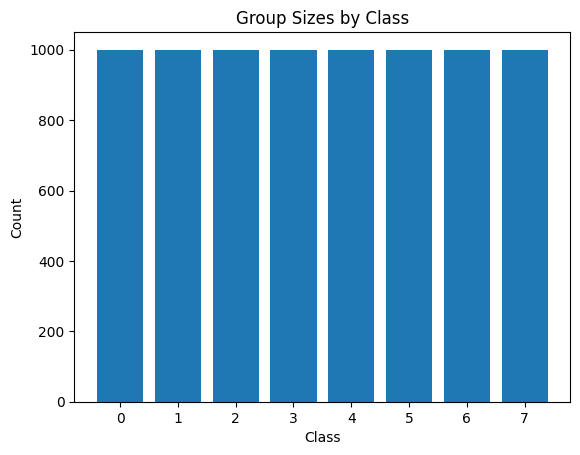

In [44]:
# Group the DataFrame by 'class' and calculate the size of each group
grouped = df.groupby('class').size()

# Create a bar plot
plt.bar(grouped.index, grouped.values)

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Group Sizes by Class')

# Show the plot
plt.show()

## Linear Discriminant Analysis (LDA)
LDA is supervised learning dimensionality reduction technique and Machine Learning classifier.

LDA aims to maximize the distance between the mean of each class and minimize the spreading within the class itself. LDA uses therefore within classes and between classes as measures. This is a good choice because maximizing the distance between the means of each class when projecting the data in a lower-dimensional space can lead to better classification results (thanks to the reduced overlap between the different classes).

When using LDA, is assumed that the input data follows a Gaussian Distribution (like in this case), therefore applying LDA to not Gaussian data can possibly lead to poor classification results.

In this example, we will run LDA to reduce our dataset to just one feature, test its accuracy

In [87]:
lda = LinearDiscriminantAnalysis(n_components=7)

# run an LDA and use it to transform the features
X_lda = lda.fit(X, Y).transform(X)

## Split dataset into train and test

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_lda,Y,
                                                    test_size = 0.1,
                                                    random_state=1984)

## Random forest

In [12]:
trainedforest = RandomForestClassifier(n_estimators=700).fit(X_train,y_train)
predictionforest = trainedforest.predict(X_test)

In [13]:
print(classification_report(y_test,predictionforest))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       119
           1       0.83      0.86      0.84        88
           2       0.84      0.81      0.83       108
           3       0.89      0.97      0.93        88
           4       0.97      0.97      0.97        94
           5       0.78      0.83      0.80        87
           6       0.92      0.87      0.89       105
           7       0.92      0.91      0.91       111

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800



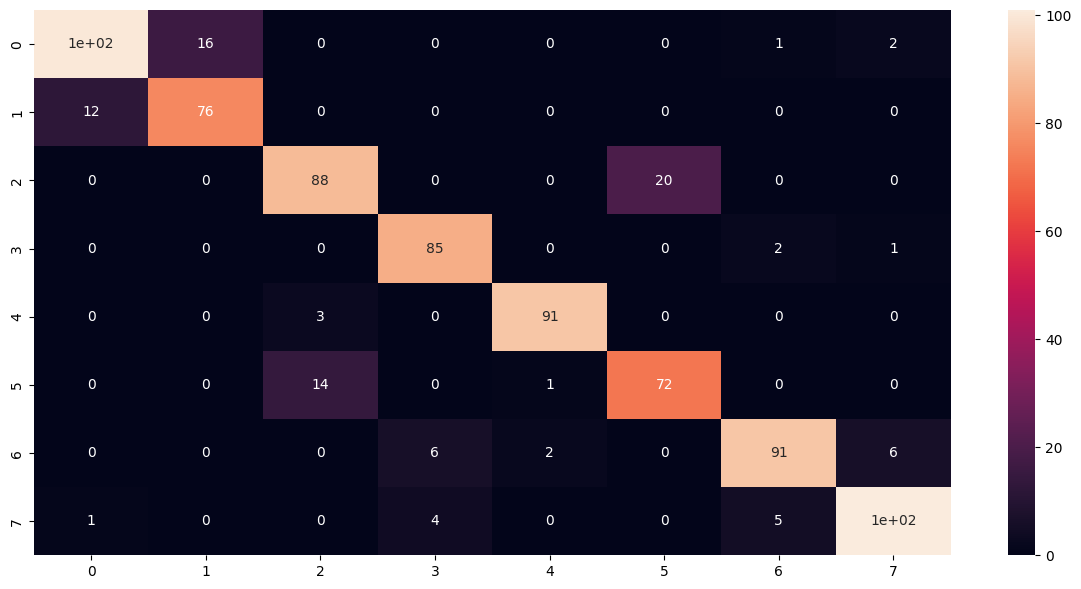

In [14]:
from sklearn.metrics import confusion_matrix,accuracy_score
con = confusion_matrix(y_test,predictionforest)
plt.figure(figsize=(12,6))
sns.heatmap(con,annot=True)
plt.tight_layout()

## SVM

In [89]:
#SVM classification
svm = SVC()
svm.fit(X_train, y_train)
#predicting with svm
svm_pred = svm.predict(X_test)


In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       119
           1       0.82      0.84      0.83        88
           2       0.85      0.76      0.80       108
           3       0.89      0.98      0.93        88
           4       0.97      0.98      0.97        94
           5       0.73      0.84      0.78        87
           6       0.92      0.89      0.90       105
           7       0.94      0.89      0.92       111

    accuracy                           0.88       800
   macro avg       0.87      0.88      0.87       800
weighted avg       0.88      0.88      0.88       800



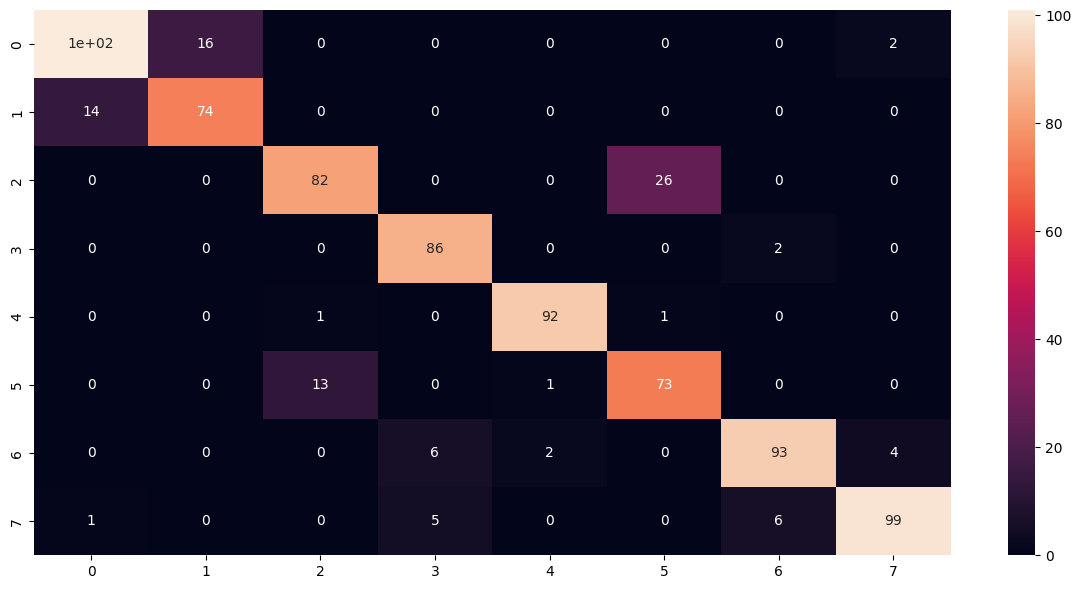

In [92]:
from sklearn.metrics import confusion_matrix,accuracy_score
con = confusion_matrix(y_test,svm_pred)
plt.figure(figsize=(12,6))
sns.heatmap(con,annot=True)
plt.tight_layout()

In [91]:
svm_acc = accuracy_score(y_test,svm_pred)
print(f"The Accuracy is :{svm_acc}")

The Accuracy is :0.875


## KNN

In [72]:
#Find the best value of hyperparameter
r = 0
i = 1
k = 1
while i <= math.sqrt(df.shape[0]):
    knn= KNeighborsClassifier(i, weights='distance', algorithm='auto' , leaf_size= 20, metric= 'minkowski')
    knn.fit(X_train, y_train)
    y_pred_knn=knn.predict(X_test)
    r2 = accuracy_score(y_test,y_pred_knn)
    if r2 > r:
        r = r2
        k = i
    i += 1

if(k%2 == 0):
    k=k+1

print("Best value of hyperparameter k:", k)

Best value of hyperparameter k: 5


In [18]:
knn = KNeighborsClassifier(5, weights='distance', algorithm='auto', leaf_size= 20, metric= 'minkowski')
knn.fit(X_train, y_train)

y_pred_knn=knn.predict(X_test)

In [21]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       119
           1       0.79      0.78      0.79        88
           2       0.85      0.74      0.79       108
           3       0.88      0.99      0.93        88
           4       0.97      0.98      0.97        94
           5       0.72      0.84      0.77        87
           6       0.92      0.88      0.90       105
           7       0.92      0.87      0.90       111

    accuracy                           0.86       800
   macro avg       0.86      0.86      0.86       800
weighted avg       0.86      0.86      0.86       800



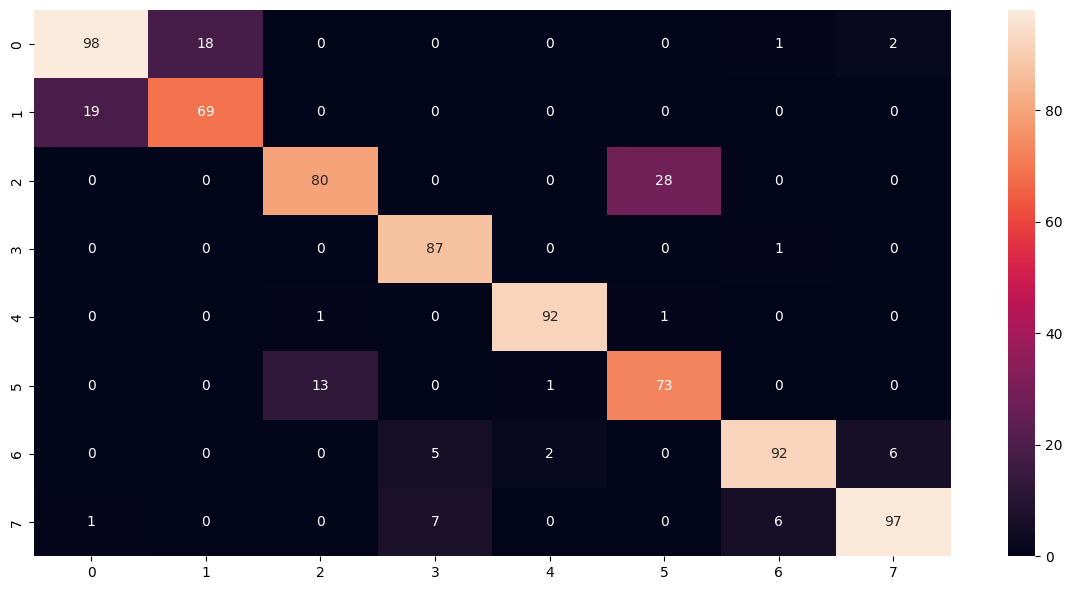

In [19]:
from sklearn.metrics import confusion_matrix,accuracy_score
con = confusion_matrix(y_test,y_pred_knn)
plt.figure(figsize=(12,6))
sns.heatmap(con,annot=True)
plt.tight_layout()

In [20]:
knn_acc = accuracy_score(y_test,y_pred_knn)
print(f"The Accuracy is :{knn_acc}")


The Accuracy is :0.86


## AdaBoost

In [22]:
from sklearn.ensemble import AdaBoostClassifier

# Create the AdaBoost regression model
adaboost_model = AdaBoostClassifier(random_state=42)

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Create the GridSearchCV object with cross-validation
grid_search = GridSearchCV(adaboost_model, param_grid, cv=5)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the GridSearchCV
best_params = grid_search.best_params_

# Create the final AdaBoost model with the best hyperparameters
final_adaboost_model = AdaBoostClassifier(random_state=42, **best_params)

# Fit the final model to the training data
final_adaboost_model.fit(X_train, y_train)

# Make predictions on the test set
adaboost_pred = final_adaboost_model.predict(X_test)

In [23]:
print(classification_report(y_test,adaboost_pred))

              precision    recall  f1-score   support

           0       0.91      0.41      0.57       119
           1       0.55      0.95      0.70        88
           2       0.58      0.92      0.71       108
           3       0.91      0.81      0.86        88
           4       0.86      0.95      0.90        94
           5       0.88      0.17      0.29        87
           6       0.95      0.78      0.86       105
           7       0.78      0.96      0.86       111

    accuracy                           0.74       800
   macro avg       0.80      0.74      0.72       800
weighted avg       0.80      0.74      0.72       800



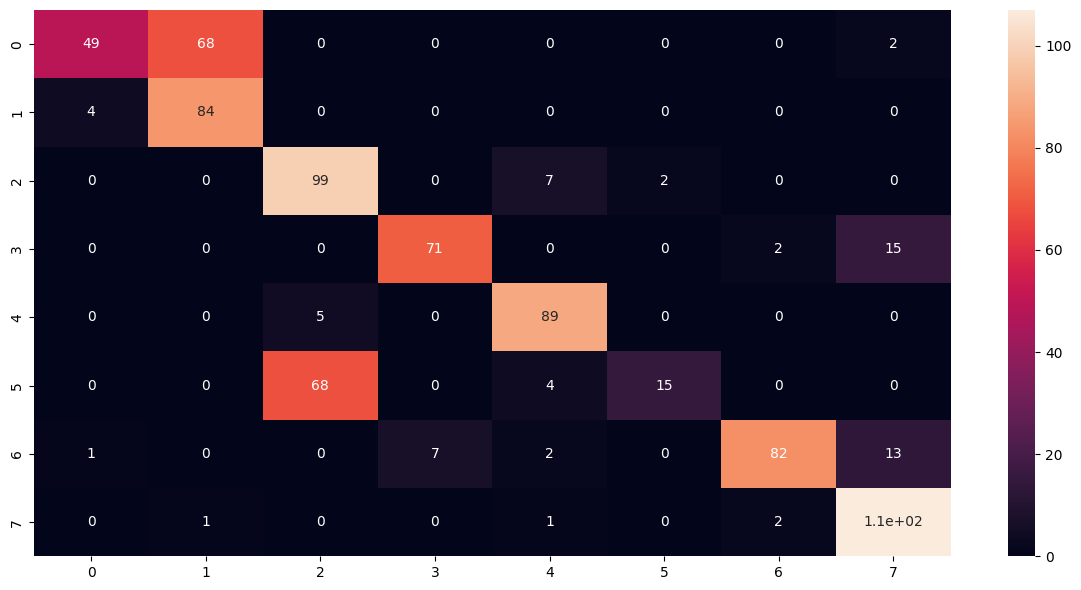

In [24]:
from sklearn.metrics import confusion_matrix,accuracy_score
con = confusion_matrix(y_test,adaboost_pred)
plt.figure(figsize=(12,6))
sns.heatmap(con,annot=True)
plt.tight_layout()

In [25]:
adaboost_acc = accuracy_score(y_test,adaboost_pred)
print(f"The Accuracy is :{adaboost_acc}")

The Accuracy is :0.745


## LightGBM

In [93]:
from lightgbm import LGBMClassifier
lgm = LGBMClassifier(random_state=42)
lgm.fit(X_train, y_train)

lgm_pred = lgm.predict(X_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 7
[LightGBM] [Info] Start training from score -2.100779
[LightGBM] [Info] Start training from score -2.066196
[LightGBM] [Info] Start training from score -2.088370
[LightGBM] [Info] Start training from score -2.066196
[LightGBM] [Info] Start training from score -2.072797
[LightGBM] [Info] Start training from score -2.065100
[LightGBM] [Info] Start training from score -2.085013
[LightGBM] [Info] Start training from score -2.091739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [94]:
print(classification_report(y_test,lgm_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       119
           1       0.86      0.88      0.87        88
           2       0.80      0.82      0.81       108
           3       0.89      0.94      0.92        88
           4       0.98      0.97      0.97        94
           5       0.78      0.77      0.77        87
           6       0.90      0.89      0.89       105
           7       0.92      0.89      0.90       111

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800



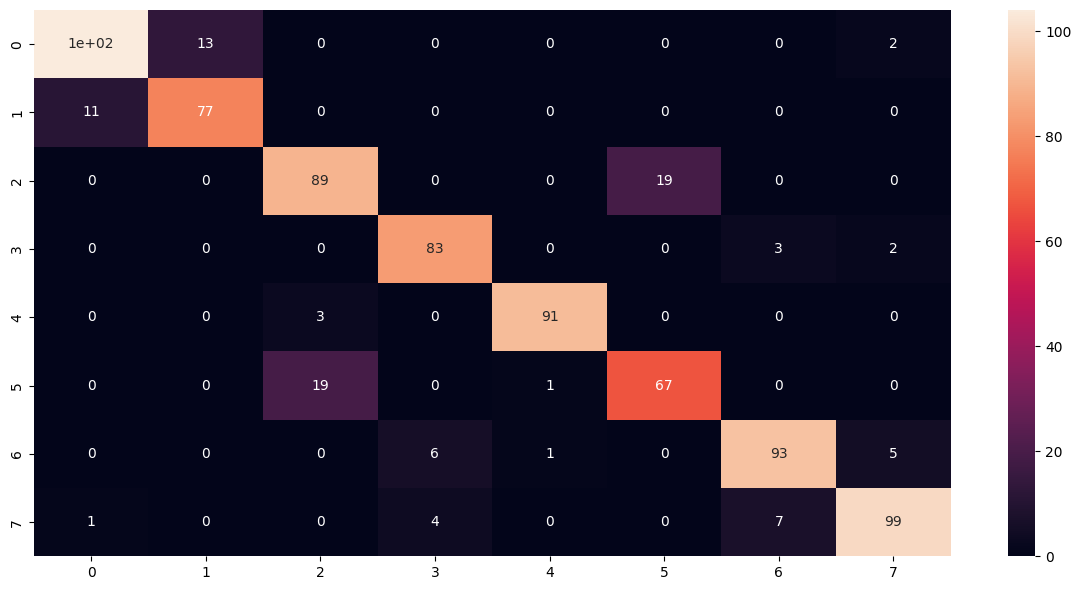

In [95]:
from sklearn.metrics import confusion_matrix,accuracy_score
con = confusion_matrix(y_test,lgm_pred)
plt.figure(figsize=(12,6))
sns.heatmap(con,annot=True)
plt.tight_layout()

In [96]:
lgm_acc = accuracy_score(y_test,lgm_pred)
print(f"The Accuracy is :{lgm_acc}")

The Accuracy is :0.87875


# Concatenate model features

## EDA

In [52]:
features1 = feature_dict_rifat['features']
features1.shape

(8000, 2048)

In [53]:
features2 = feature_dict_gaju['features'].numpy()
print(features2.shape)

(8000, 768)


In [54]:
features3 = feature_dict['features']
features3 = np.array(features3)
features3.shape

(8000, 320)

In [55]:
concatenated_features = np.concatenate((features1, features2, features3), axis=1)

In [56]:
print(concatenated_features.shape)

(8000, 3136)


In [57]:
X = concatenated_features
Y = feature_dict['label']
Y = LabelEncoder().fit_transform(Y)
X = StandardScaler().fit_transform(X)

## LDA

In [58]:
lda = LinearDiscriminantAnalysis(n_components=7)

# run an LDA and use it to transform the features
X_lda = lda.fit(X, Y).transform(X)


## Split dataset into train and test

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_lda,Y,
                                                    test_size = 0.1,
                                                    random_state=1984)

## Random forest

In [60]:
trainedforest = RandomForestClassifier(n_estimators=700).fit(X_train,y_train)
predictionforest = trainedforest.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00        88
           2       0.99      0.98      0.99       108
           3       1.00      1.00      1.00        88
           4       1.00      1.00      1.00        94
           5       0.98      0.99      0.98        87
           6       1.00      1.00      1.00       105
           7       1.00      1.00      1.00       111

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



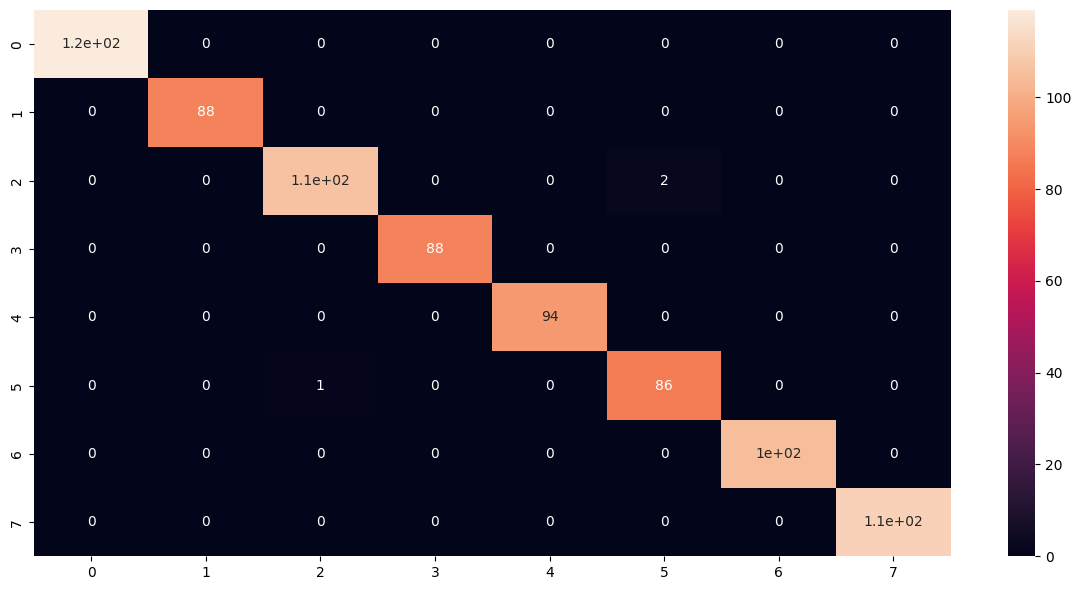

In [61]:
from sklearn.metrics import confusion_matrix,accuracy_score
con = confusion_matrix(y_test,predictionforest)
plt.figure(figsize=(12,6))
sns.heatmap(con,annot=True)
plt.tight_layout()
print(classification_report(y_test,predictionforest))

In [77]:
rf_acc = accuracy_score(y_test,predictionforest)
print(f"The Accuracy is :{rf_acc}")

The Accuracy is :0.99625


## SVM

In [62]:
#SVM classification
svm = SVC()
svm.fit(X_train, y_train)
#predicting with svm
svm_pred = svm.predict(X_test)


In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00        88
           2       0.98      0.99      0.99       108
           3       1.00      1.00      1.00        88
           4       1.00      1.00      1.00        94
           5       0.99      0.98      0.98        87
           6       1.00      1.00      1.00       105
           7       1.00      1.00      1.00       111

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



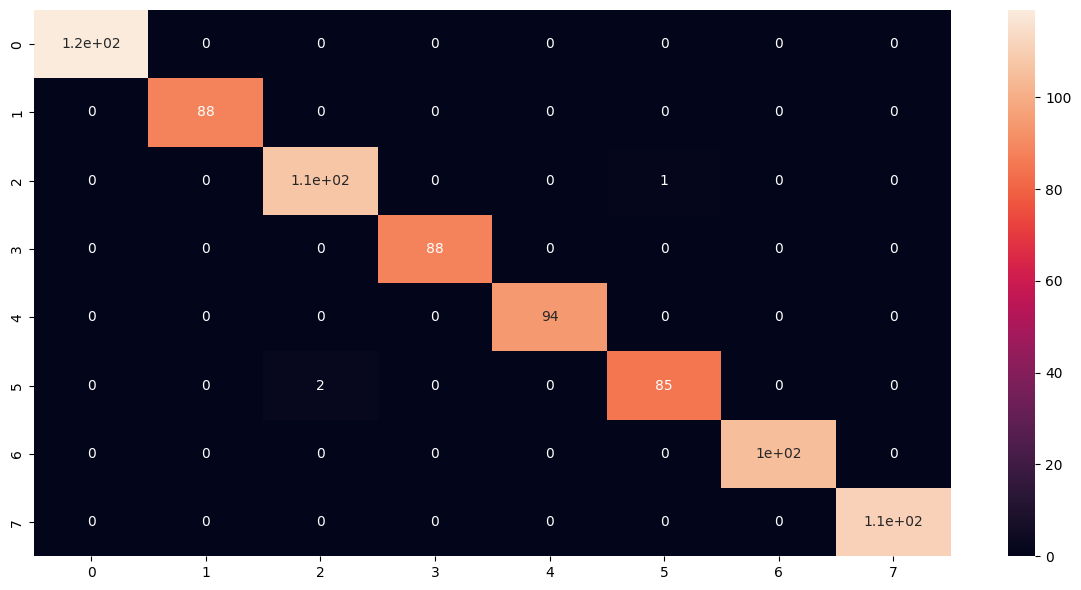

In [64]:
from sklearn.metrics import confusion_matrix,accuracy_score
con = confusion_matrix(y_test,svm_pred)
plt.figure(figsize=(12,6))
sns.heatmap(con,annot=True)
plt.tight_layout()

In [65]:
svm_acc = accuracy_score(y_test,svm_pred)
print(f"The Accuracy is :{svm_acc}")

The Accuracy is :0.99625


## KNN

In [66]:
knn = KNeighborsClassifier(5, weights='distance', algorithm='auto', leaf_size= 20, metric= 'minkowski')
knn.fit(X_train, y_train)

y_pred_knn=knn.predict(X_test)

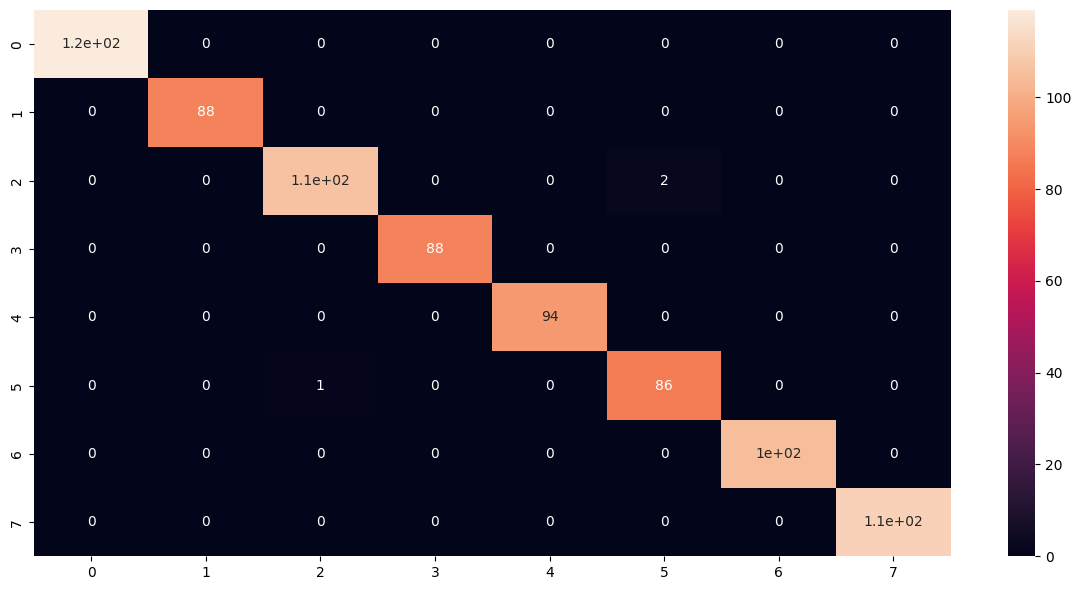

In [67]:
from sklearn.metrics import confusion_matrix,accuracy_score
con = confusion_matrix(y_test,y_pred_knn)
plt.figure(figsize=(12,6))
sns.heatmap(con,annot=True)
plt.tight_layout()

In [68]:
knn_acc = accuracy_score(y_test,y_pred_knn)
print(f"The Accuracy is :{knn_acc}")


The Accuracy is :0.99625


## AdaBoost

In [69]:
from sklearn.ensemble import AdaBoostClassifier

# Create the AdaBoost regression model
adaboost_model = AdaBoostClassifier(random_state=42)

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Create the GridSearchCV object with cross-validation
grid_search = GridSearchCV(adaboost_model, param_grid, cv=5)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the GridSearchCV
best_params = grid_search.best_params_

# Create the final AdaBoost model with the best hyperparameters
final_adaboost_model = AdaBoostClassifier(random_state=42, **best_params)

# Fit the final model to the training data
final_adaboost_model.fit(X_train, y_train)

# Make predictions on the test set
adaboost_pred = final_adaboost_model.predict(X_test)

In [70]:
print(classification_report(y_test,adaboost_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00        88
           2       0.96      0.99      0.98       108
           3       1.00      1.00      1.00        88
           4       0.99      1.00      0.99        94
           5       0.99      0.95      0.97        87
           6       1.00      1.00      1.00       105
           7       1.00      0.99      1.00       111

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



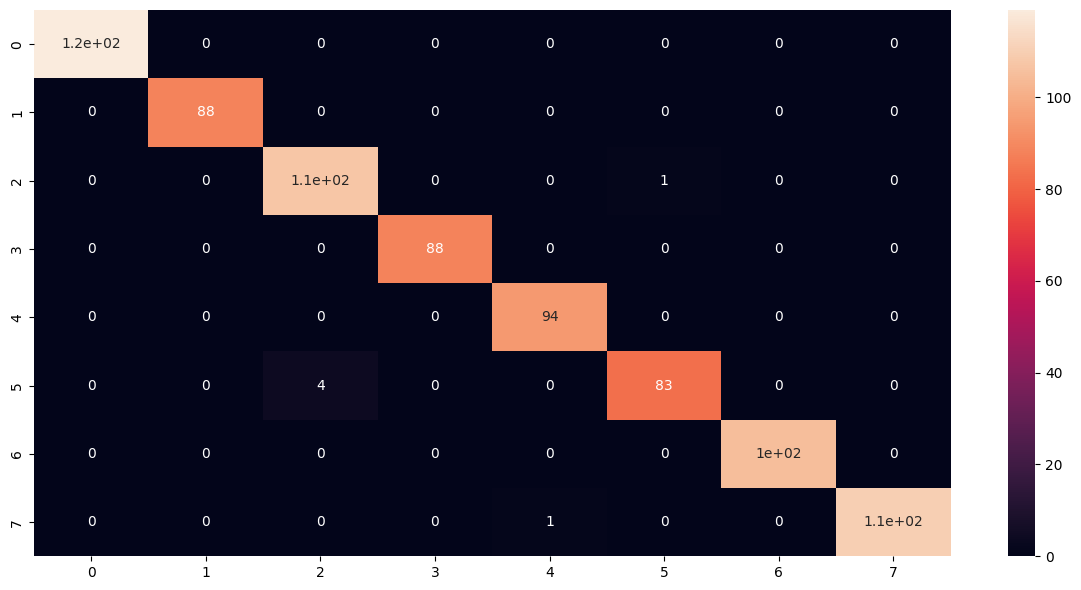

In [71]:
from sklearn.metrics import confusion_matrix,accuracy_score
con = confusion_matrix(y_test,adaboost_pred)
plt.figure(figsize=(12,6))
sns.heatmap(con,annot=True)
plt.tight_layout()

In [72]:
adaboost_acc = accuracy_score(y_test,adaboost_pred)
print(f"The Accuracy is :{adaboost_acc}")

The Accuracy is :0.9925


## LightGBM

In [ ]:
from lightgbm import LGBMClassifier
lgm = LGBMClassifier(random_state=42)
lgm.fit(X_train, y_train)

lgm_pred = lgm.predict(X_test)

In [74]:
print(classification_report(y_test,lgm_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00        88
           2       0.99      0.98      0.99       108
           3       1.00      1.00      1.00        88
           4       1.00      1.00      1.00        94
           5       0.98      0.99      0.98        87
           6       1.00      1.00      1.00       105
           7       1.00      1.00      1.00       111

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



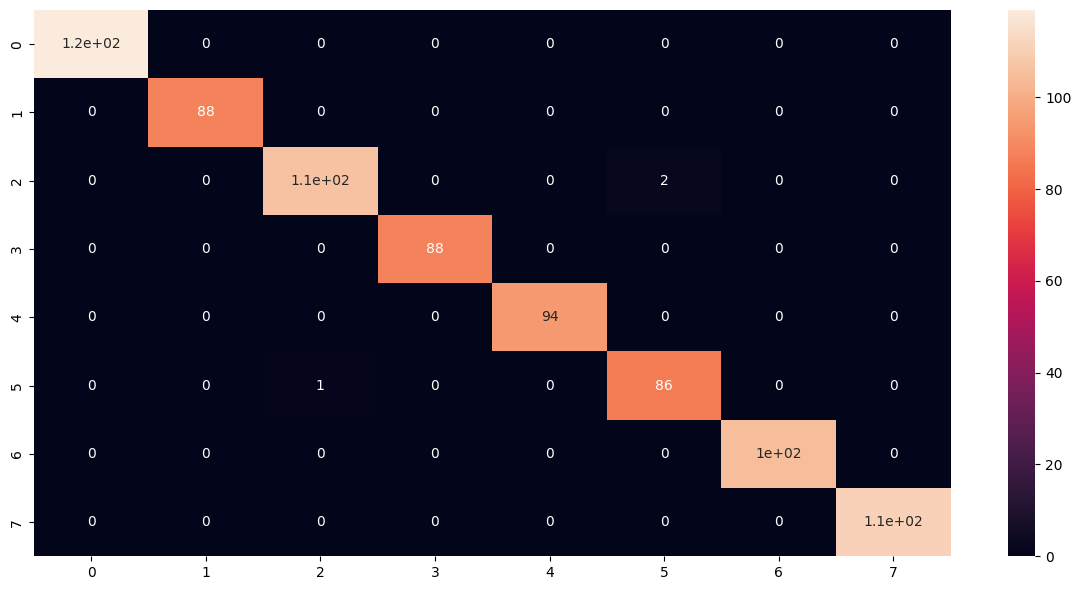

In [75]:
from sklearn.metrics import confusion_matrix,accuracy_score
con = confusion_matrix(y_test,lgm_pred)
plt.figure(figsize=(12,6))
sns.heatmap(con,annot=True)
plt.tight_layout()

# Feature Extraction and Classification

In this feature extraction and classification task, we leverage a pre-trained EfficientViT (Vision Transformer) model in PyTorch to extract image features and reduce their dimensionality. The goal is to demonstrate the process of utilizing a deep learning model for feature extraction and subsequently applying various machine learning classifiers to achieve image classification. This approach can be valuable for a wide range of downstream applications, including image recognition, object detection, and content-based image retrieval.

## Model Selection

I utilize the 'efficientvit_m3' model architecture from the Timm library, a collection of pre-trained models for PyTorch. The chosen model is loaded without the final classification head, effectively turning it into a feature extractor.

## Checkpoint Loading

A pre-trained model checkpoint is loaded from the specified file path. This checkpoint likely contains the weights and parameters of a model that has been trained for image classification.

## Image Feature Extraction

The code then loops through a directory containing images, loading each image one by one. For each image:

1. The image is preprocessed using the same transformation used during training. This typically includes resizing and normalization.

2. A forward pass is made through the EfficientViT model. This results in a set of features for the image.

3. The features are flattened into a one-dimensional tensor.

4. A linear layer is added to further reduce the dimensionality of the features to 2600 dimensions.

5. The features are converted to a NumPy array.

6. The class label (inferred from the subdirectory of the image) is appended to the end of the feature array.

7. The image filename is used as a unique identifier, and the feature array is stored in a dictionary with the filename as the key.

## Feature Transformation with LDA

1. Feature Extraction: Features are extracted from images using a pre-trained model and flattened.

2. Data Preparation: Extracted features are converted into a DataFrame for further processing.

3. Label Encoding: Class labels are encoded for classification.

4. Standardization: Feature values are standardized to have zero mean and unit variance.

5. Linear Discriminant Analysis (LDA): LDA is applied to reduce feature dimensionality to 7 components.

## Classification
For image classification, we employ several machine learning classifiers on two types of features: EfficientViTM3 features and concatenated model features. Here are the results for each classifie

## Classification for EfficientViTM3 features


| Model                       | Accuracy   |
|-----------------------------|------------|
| Random Forest               | 0.88      |
| LightGBM                    | 0.88      |
| Support Vector Machine(SVM)| 0.875    |
| k-Nearest Neighbors(KNN)  | 0.86   |
| Adaboost                    | 0.745      |

## Classification for Concatenate model features


| Model                       | Accuracy   |
|-----------------------------|------------|
| Random Forest               | 0.99625      |
| Support Vector Machine(SVM)| 0.99625    |
| k-Nearest Neighbors(KNN)  | 0.99625   |
| LightGBM                    | 0.99625      |
| Adaboost                    | 0.9925      |

## Conclusion
In this task, we demonstrated the process of utilizing a pre-trained EfficientViT model for image feature extraction, dimensionality reduction with LDA, and image classification using various machine learning classifiers. The results showed that the concatenated model features significantly outperformed the EfficientViTM3 features across all classifiers, indicating the effectiveness of the feature transformation process.

The use of deep learning models for feature extraction followed by machine learning classifiers allows for robust image classification in various applications, including object recognition, content-based image retrieval, and more. The choice of classifiers should be based on the specific requirements and characteristics of the dataset, and hyperparameter tuning can further improve classification performance. Overall, this approach provides a valuable framework for leveraging pre-trained models and machine learning techniques for image analysis tasks.
